# 学習方法の例

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from common.layers import *
from sklearn.model_selection import train_test_split
import pickle

C:\Users\onoza\Anaconda3\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


## データを読む1

In [2]:
#train_data = np.load("../1_data/train_data.npy")
#train_label = np.load("../1_data/train_label.npy")
train_data = np.load("../1_data/imagedatagenerator/train_data_expansion.npy")
train_label = np.load("../1_data/imagedatagenerator/train_label_expansion.npy")

print("train_data.shape=", train_data.shape)
print("train_label.shape=", train_label.shape)

#データ拡張
#train_data_expansion = np.load("../1_data/imagedatagenerator/train_data_expansion.npy")
#train_label_expansion = np.load("../1_data/imagedatagenerator/train_label_expansion.npy")
#print("train_data_expansion.shape=", train_data_expansion.shape)
#print("train_label_expansion.shape=", train_label_expansion.shape)
#
#train_data = np.concatenate([train_data, train_data_expansion])
#train_label = np.concatenate([train_label, train_label_expansion])
#
#print("train_data.shape=", train_data.shape)
#print("train_label.shape=", train_label.shape)

train_data.shape= (3000, 1, 28, 28)
train_label.shape= (3000, 15)


In [3]:
from PIL import Image

def show_image(img): 
    pil_img = Image.fromarray(img)
    plt.imshow(pil_img)
    plt.gray()
    plt.show()
    return

#for i in range(3000):
#    
#    if(0.98<np.random.rand()):        
#        img = train_data[i]
#        img = img.reshape(28,28)
#        img = np.uint8(img*255)
#        show_image(img)
#
#        img = train_data[3000+i]
#        img = img.reshape(28,28)
#        img = np.uint8(img*255)
#        show_image(img)

In [4]:
# 正規化
print(train_data.max())
print(train_data.min())

train_data = (train_data - train_data.min()) / train_data.max()
train_data = train_data.astype('float32')
# print(train_data)

255.0
0.0


In [5]:
# 配列形式変更
train_data = train_data.reshape(-1, 28*28)
print("train_data.shape=", train_data.shape)

train_data.shape= (3000, 784)


## trainとtestに分割する

In [6]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.3, random_state=1234, shuffle=True)

print(X_train.shape, X_test.shape)

(2100, 784) (900, 784)


## 学習

In [7]:
epochs = 20
batch_size = 32
lr = 0.01

# 繰り返し回数
xsize = X_train.shape[0]
iter_num = np.ceil(xsize / batch_size).astype(np.int)

# 2層NNのオブジェクト生成
#tnet = ThreeLayerNet(input_size=28*28, hidden_size=50, output_size=15)
tnet = MultiLayerNetExtend(input_size=28*28,
                                hidden_size_list=[300, 300, 300],
                                output_size=15, 
                                weight_init_std='relu',
                                weight_decay_lambda=0.01, 
                                use_dropout = False, dropout_ration = 0.5,
                                use_batchnorm=True)

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
for epoch in range(epochs):
    print("epoch=%s"%epoch)
    
    # シャッフル
    idx = np.arange(xsize)
    np.random.shuffle(idx)

    #勾配法の選択
    #optimizer = SGD(lr=0.01)
    optimizer = RMSProp(lr=0.0001,rho=0.9)
    #optimizer = Momentum(lr=0.01, momentum=0.9)
    #optimizer = NesterovAG(lr=0.01, momentum=0.9)
    #optimizer = Adam(lr=0.001, rho1=0.9, rho2=0.999)
    
    for it in range(iter_num):
        """
        ランダムなミニバッチを順番に取り出す
        """
        mask = idx[batch_size*it : batch_size*(it+1)]
    
        # ミニバッチの生成
        x_ = X_train[mask]
        y_ = y_train[mask]
        
        # 勾配の計算
        grads = tnet.gradient(x_, y_)

        # パラメータの更新
        #for key in tnet.params.keys():
    #         print(key)
            #tnet.params[key] -= lr * grads[key]
        optimizer.update(tnet.params, grads)
        
        #for key in tnet.params.keys():
        #    #print(key)
        #    tnet.params[key] = params[key]


    ## 学習経過の記録
    
    # 訓練データにおけるloss
    train_loss.append(tnet.loss(X_train,  y_train))
    
    # テストデータにおけるloss
    test_loss.append(tnet.loss(X_test, y_test))
    
    # 訓練データにて精度を確認
    train_accuracy.append(tnet.accuracy(X_train, y_train))

    # テストデータにて精度を算出
    test_accuracy.append(tnet.accuracy(X_test, y_test))

epoch=0
epoch=1
epoch=2
epoch=3
epoch=4
epoch=5
epoch=6
epoch=7
epoch=8
epoch=9
epoch=10
epoch=11
epoch=12
epoch=13
epoch=14
epoch=15
epoch=16
epoch=17
epoch=18
epoch=19


    train_loss  test_loss  train_accuracy  test_accuracy
0    10.480701  10.681509        0.620476       0.498889
1     9.667486   9.916932        0.813810       0.720000
2     9.135174   9.424132        0.881905       0.772222
3     8.718912   9.037003        0.918571       0.802222
4     8.323709   8.660195        0.947619       0.827778
5     7.949177   8.313752        0.972381       0.838889
6     7.587001   7.962609        0.981429       0.856667
7     7.239725   7.635842        0.988571       0.855556
8     6.917572   7.339953        0.977619       0.845556
9     6.530977   6.952306        0.993810       0.861111
10    6.206168   6.622162        0.992381       0.861111
11    5.859324   6.287107        0.997143       0.863333
12    5.516259   5.929882        0.999048       0.883333
13    5.175443   5.610156        0.999524       0.862222
14    4.909455   5.392573        0.978571       0.841111
15    4.569917   5.037607        0.995238       0.856667
16    4.247148   4.692791      

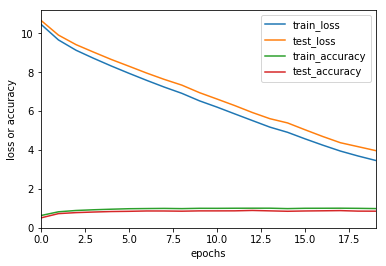

In [8]:
# lossのグラフ化
df_log = pd.DataFrame({"train_loss":train_loss,
             "test_loss":test_loss,
             "train_accuracy":train_accuracy,
             "test_accuracy":test_accuracy})
print(df_log)
df_log.plot()
plt.ylabel("loss or accuracy")
plt.xlabel("epochs")
plt.show()

predict_label ku
correct_label a


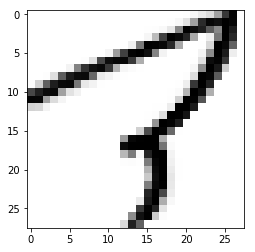

predict_label sa
correct_label so


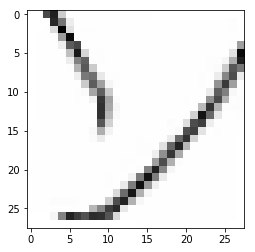

predict_label ku
correct_label u


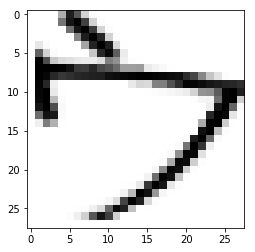

predict_label so
correct_label si


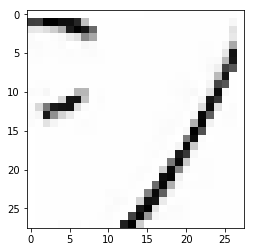

predict_label o
correct_label sa


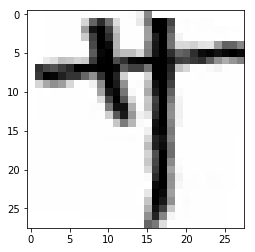

predict_label se
correct_label i


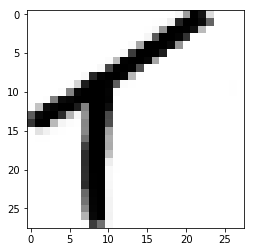

predict_label ku
correct_label ka


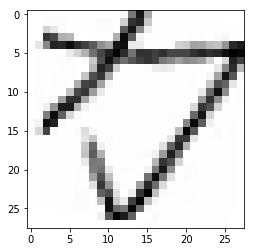

predict_label sa
correct_label ka


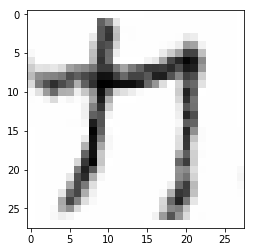

predict_label su
correct_label ku


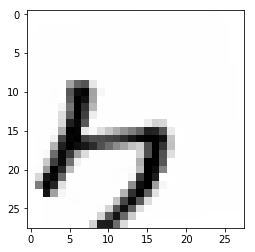

predict_label ku
correct_label si


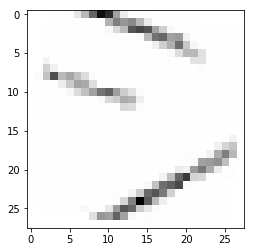

predict_label ke
correct_label sa


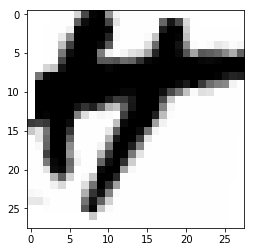

predict_label ku
correct_label si


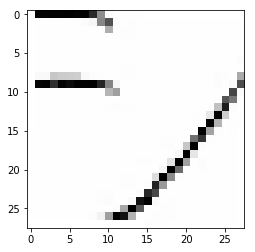

predict_label sa
correct_label so


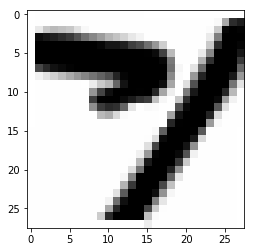

predict_label sa
correct_label ka


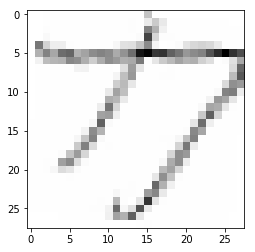

predict_label ku
correct_label si


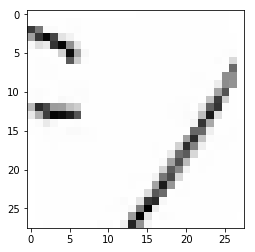

predict_label ke
correct_label u


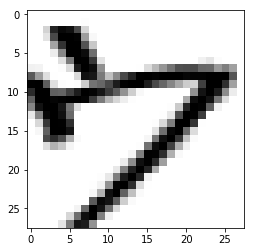

predict_label a
correct_label su


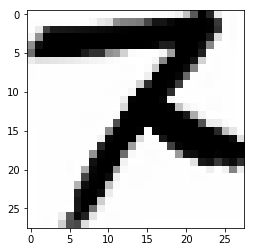

predict_label ku
correct_label si


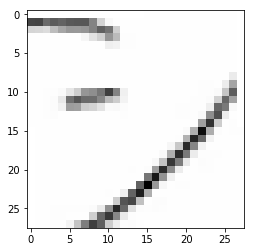

predict_label ku
correct_label u


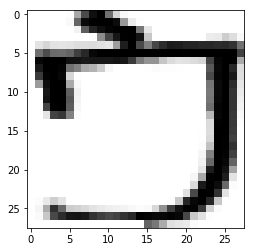

predict_label sa
correct_label ka


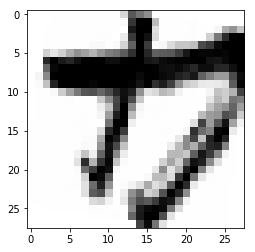

predict_label ku
correct_label ko


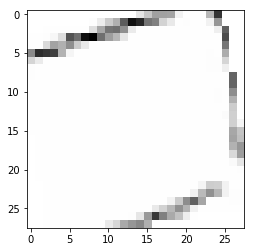

predict_label ke
correct_label se


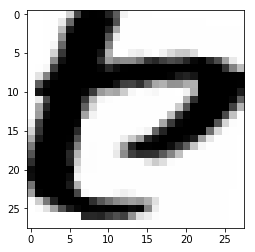

predict_label ki
correct_label ke


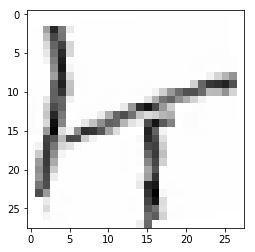

predict_label sa
correct_label si


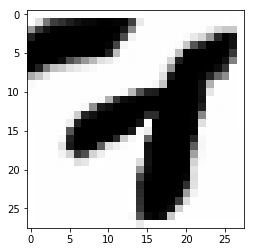

predict_label ke
correct_label sa


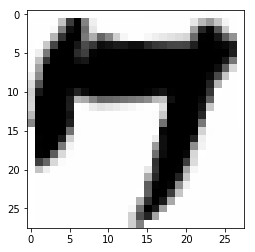

predict_label ku
correct_label sa


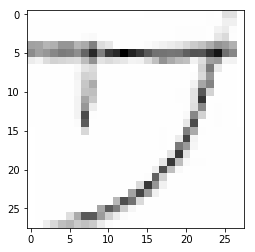

predict_label i
correct_label a


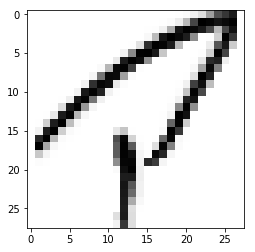

predict_label sa
correct_label ke


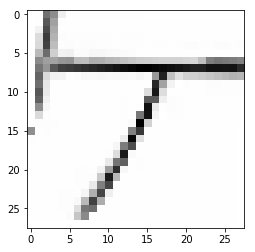

predict_label i
correct_label sa


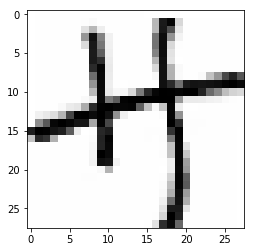

predict_label sa
correct_label si


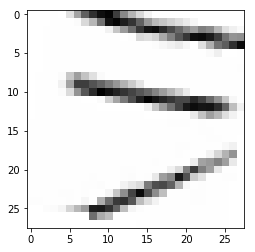

predict_label ke
correct_label si


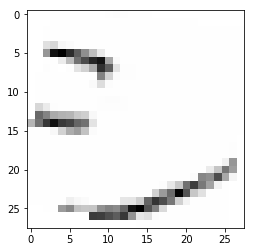

predict_label se
correct_label si


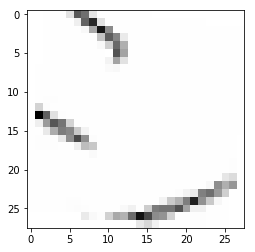

predict_label ku
correct_label ke


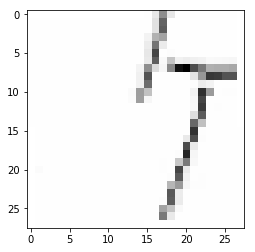

predict_label ku
correct_label si


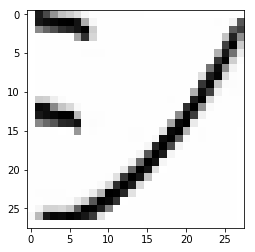

predict_label ki
correct_label si


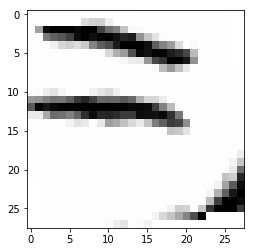

predict_label ku
correct_label u


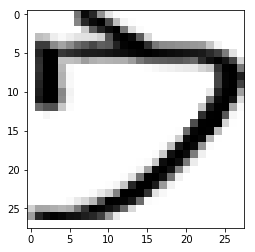

predict_label ku
correct_label si


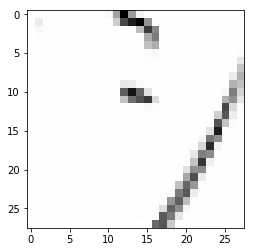

predict_label ku
correct_label so


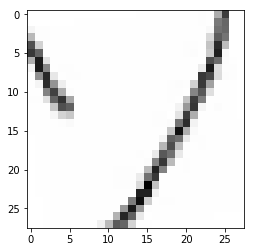

predict_label ku
correct_label so


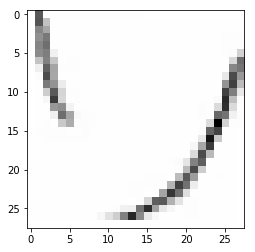

predict_label sa
correct_label ke


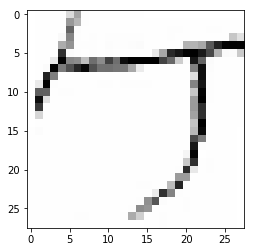

predict_label ki
correct_label e


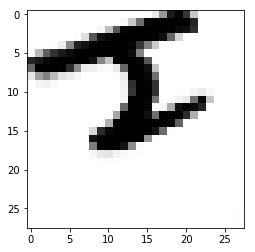

predict_label ku
correct_label si


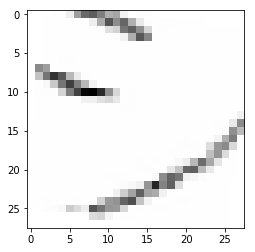

predict_label ku
correct_label si


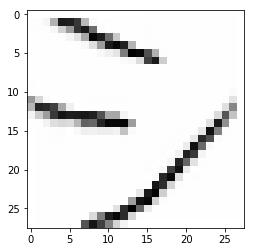

predict_label ku
correct_label ka


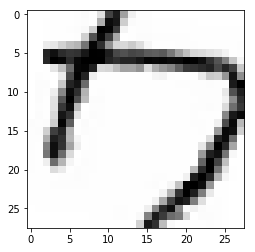

predict_label ka
correct_label si


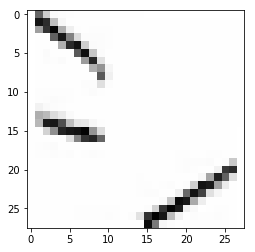

predict_label so
correct_label si


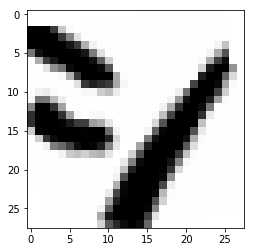

predict_label ku
correct_label si


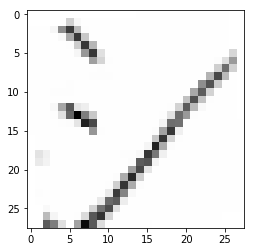

predict_label sa
correct_label ke


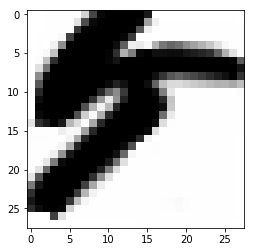

predict_label ka
correct_label se


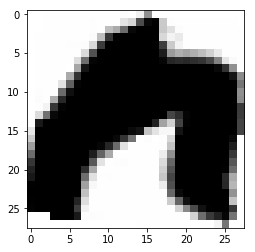

predict_label ke
correct_label ka


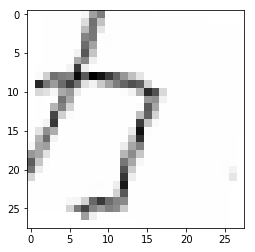

predict_label ku
correct_label ko


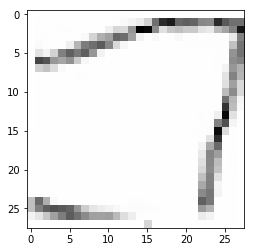

predict_label ki
correct_label ke


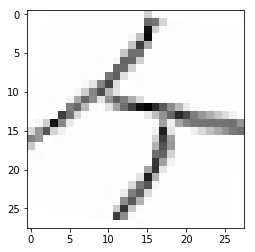

predict_label se
correct_label su


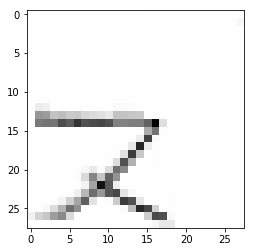

predict_label i
correct_label se


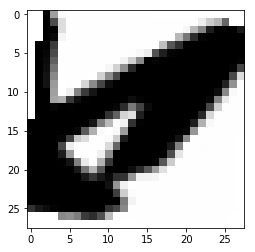

predict_label ko
correct_label ku


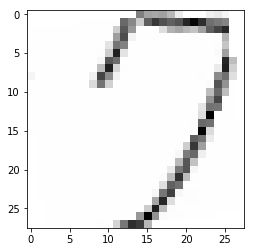

predict_label ki
correct_label sa


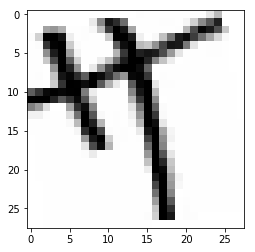

predict_label a
correct_label ku


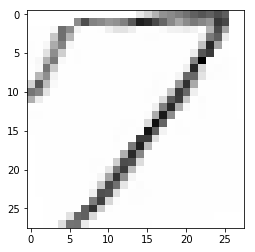

predict_label ku
correct_label si


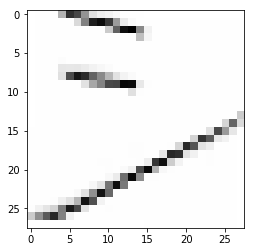

predict_label ku
correct_label a


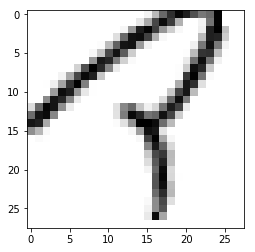

predict_label ku
correct_label so


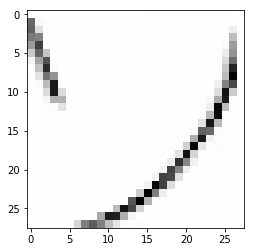

predict_label ke
correct_label ku


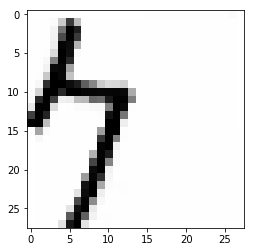

predict_label si
correct_label so


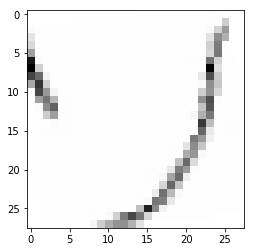

predict_label ki
correct_label so


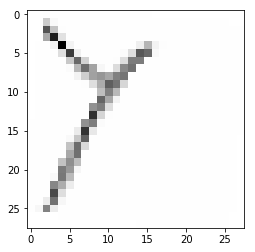

predict_label ku
correct_label ke


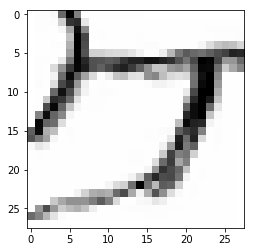

predict_label ka
correct_label ku


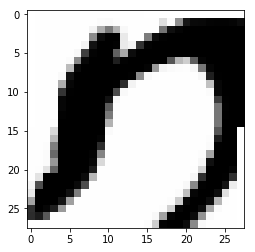

predict_label ku
correct_label si


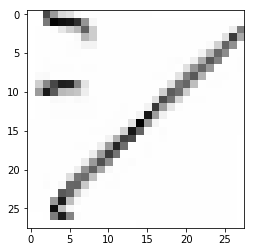

predict_label ku
correct_label si


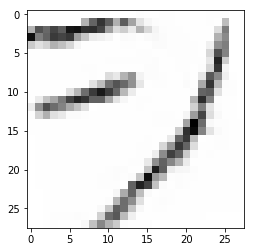

predict_label se
correct_label si


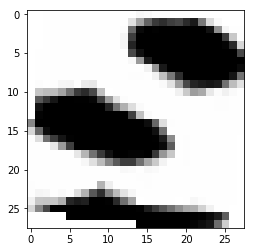

predict_label ki
correct_label su


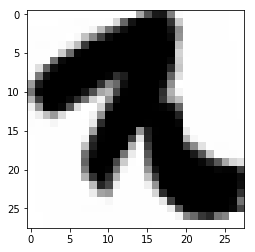

predict_label ka
correct_label u


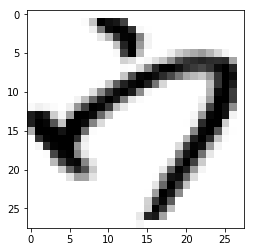

predict_label ki
correct_label e


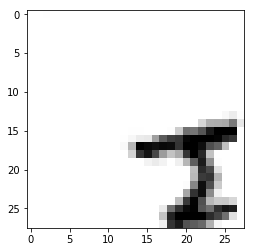

predict_label ku
correct_label si


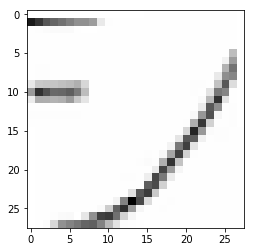

predict_label ku
correct_label sa


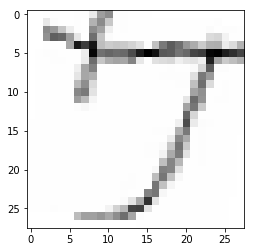

predict_label ku
correct_label a


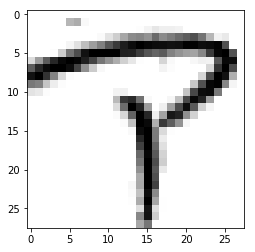

predict_label ku
correct_label ka


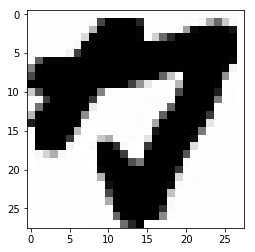

predict_label u
correct_label ka


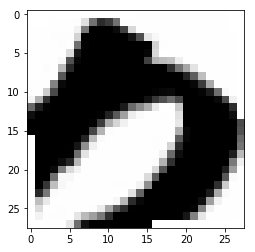

predict_label se
correct_label so


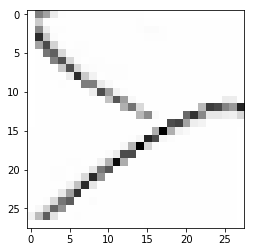

predict_label sa
correct_label ka


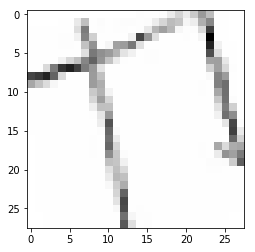

predict_label ka
correct_label u


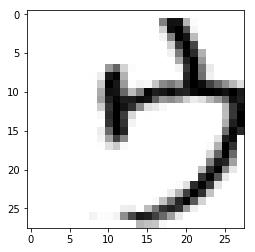

predict_label e
correct_label si


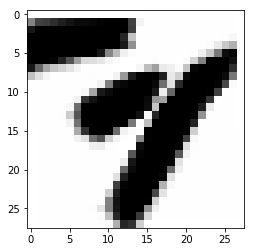

predict_label i
correct_label o


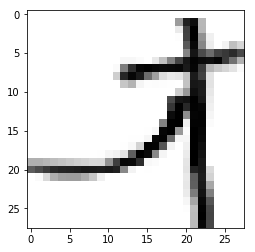

predict_label ka
correct_label se


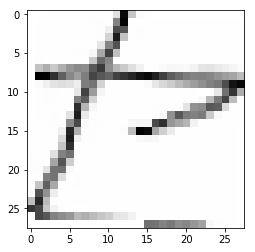

predict_label su
correct_label e


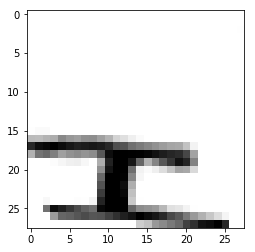

predict_label su
correct_label e


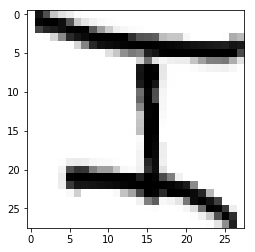

predict_label sa
correct_label so


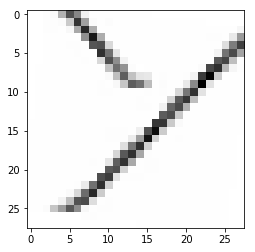

predict_label so
correct_label si


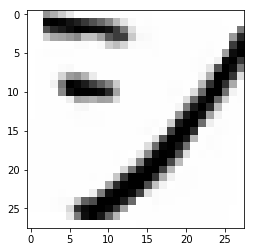

predict_label ku
correct_label ko


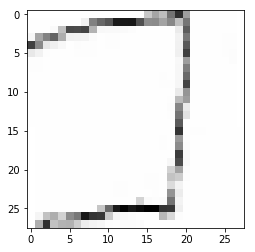

predict_label ko
correct_label so


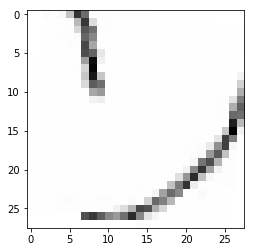

predict_label ku
correct_label si


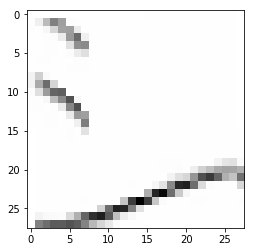

predict_label sa
correct_label se


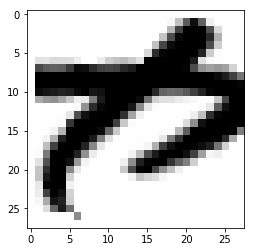

predict_label u
correct_label si


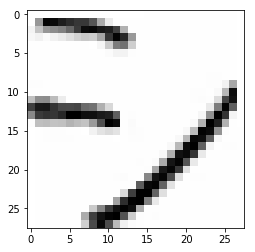

predict_label ku
correct_label so


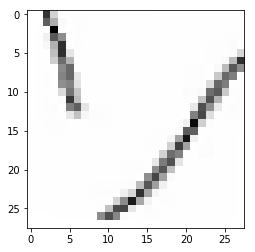

predict_label ki
correct_label ko


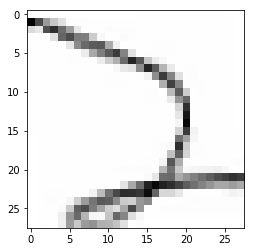

predict_label ku
correct_label ke


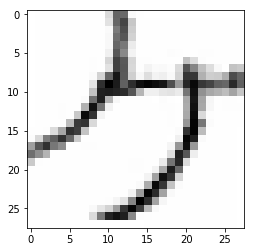

predict_label ke
correct_label i


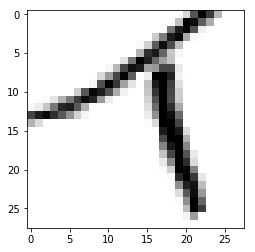

predict_label o
correct_label a


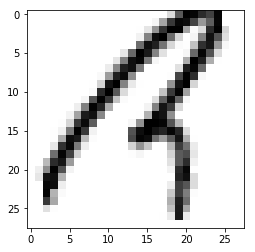

predict_label ku
correct_label u


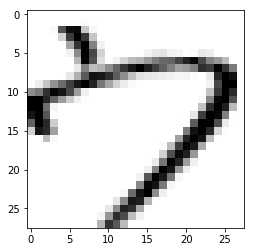

predict_label ka
correct_label ku


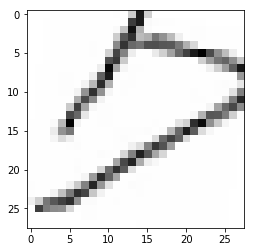

predict_label a
correct_label i


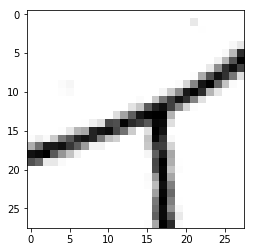

predict_label ku
correct_label si


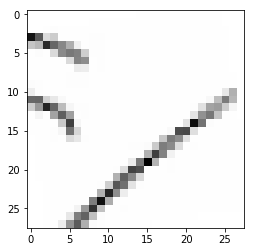

predict_label o
correct_label ki


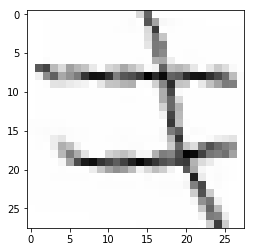

predict_label sa
correct_label ke


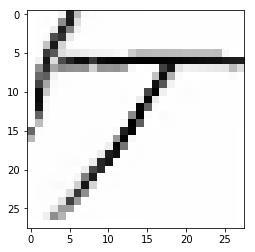

predict_label ku
correct_label so


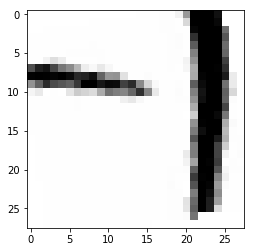

predict_label ka
correct_label se


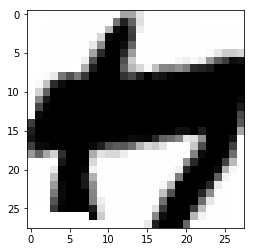

predict_label ku
correct_label ka


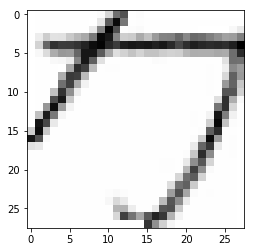

predict_label ka
correct_label se


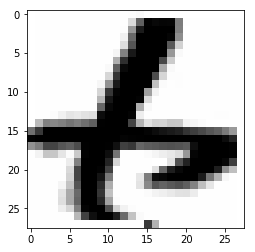

predict_label o
correct_label a


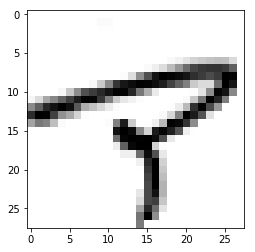

predict_label se
correct_label sa


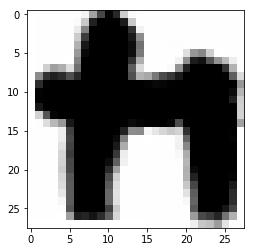

predict_label ku
correct_label si


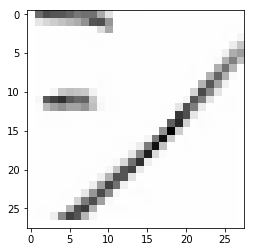

predict_label ko
correct_label si


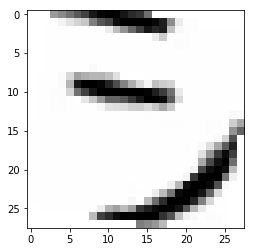

predict_label sa
correct_label i


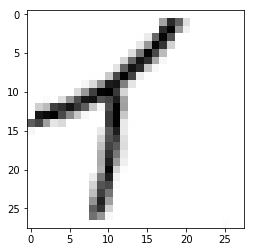

predict_label ku
correct_label si


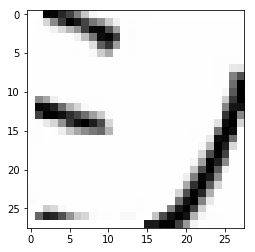

predict_label se
correct_label ka


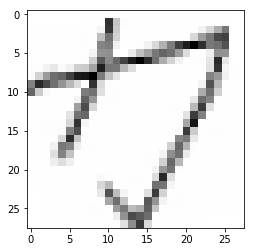

predict_label ke
correct_label ka


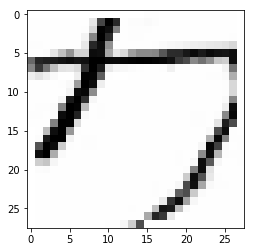

predict_label ku
correct_label sa


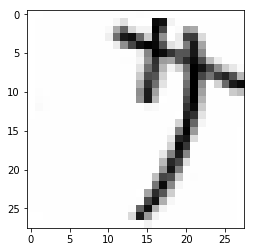

predict_label ku
correct_label si


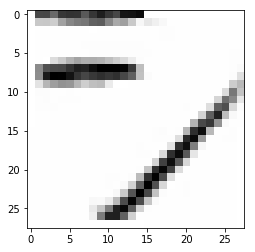

predict_label ka
correct_label se


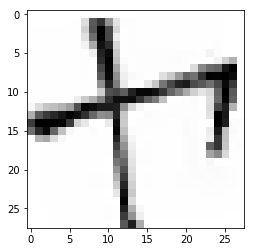

predict_label o
correct_label i


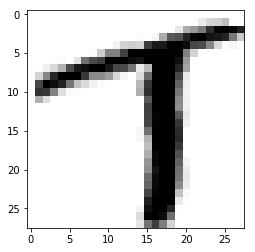

predict_label sa
correct_label ki


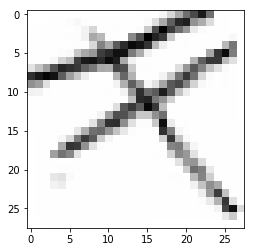

predict_label so
correct_label i


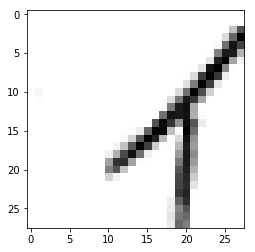

predict_label sa
correct_label ke


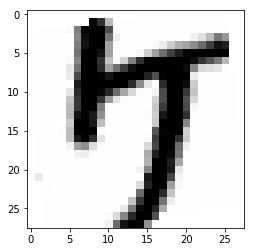

predict_label ku
correct_label si


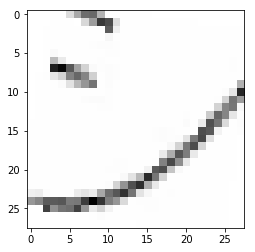

predict_label ku
correct_label si


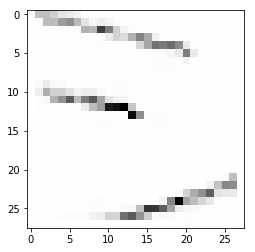

predict_label ku
correct_label si


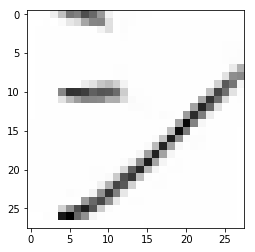

predict_label ka
correct_label ku


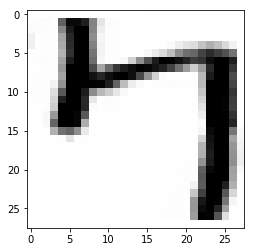

predict_label ka
correct_label sa


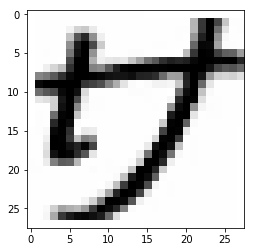

predict_label ki
correct_label se


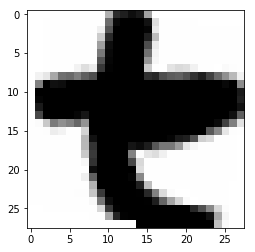

predict_label su
correct_label si


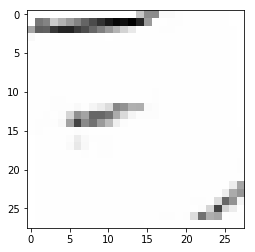

predict_label ku
correct_label si


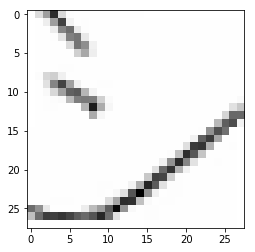

predict_label sa
correct_label a


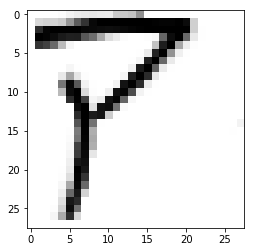

predict_label se
correct_label sa


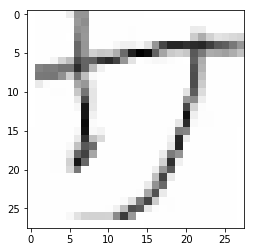

predict_label ke
correct_label sa


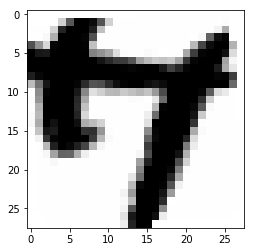

predict_label ka
correct_label sa


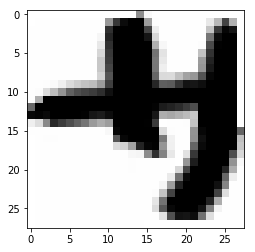

predict_label ko
correct_label o


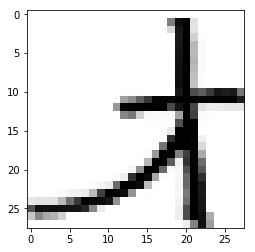

predict_label ka
correct_label si


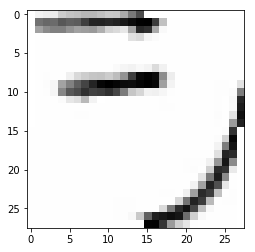

predict_label ku
correct_label ka


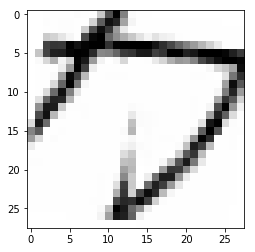

predict_label sa
correct_label ka


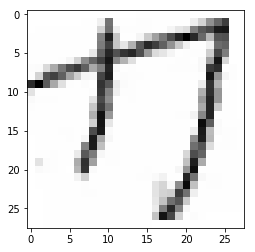

predict_label sa
correct_label ke


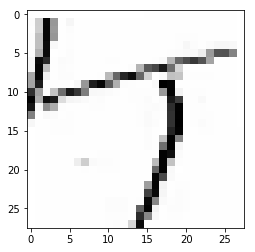

predict_label ki
correct_label si


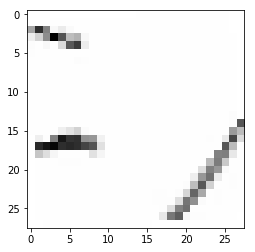

miss_summary

a 7.0
i 6.0
u 7.0
e 4.0
o 2.0
ka 14.0
ki 2.0
ku 7.0
ke 11.0
ko 4.0
sa 13.0
si 38.0
su 3.0
se 9.0
so 12.0


In [9]:
#間違った画像を表示
tnet.display_miss_img(X_test, y_test)

## 学習済みモデルの出力

In [10]:
with open("katakana_model.pickle", "wb") as f:
    pickle.dump(tnet, f)